# Discrete choice

This notebook generates the figures for the discrete choice section, using [statsmodels](https://statsmodels.org), [biogeme](http://biogeme.epfl.ch/), and data from the [2017 NHTS](https://nhts.ornl.gov).

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from io import StringIO
import biogeme.database as bdb
import biogeme.biogeme as bio
from biogeme.expressions import *
import biogeme.distributions
import biogeme.loglikelihood
import biogeme.models

In [2]:
trips = pd.read_csv('../data/trippub.csv')

In [3]:
trips['carpool'] = (trips.NUMONTRP > 1).astype('int8')

In [4]:
carTrips = trips[trips.TRPTRANS.isin([3, 4, 5, 6]) & (trips.DRVRCNT >= 1)].sample(n=10000, random_state=7284)

In [5]:
carTrips['carsPerDriver'] = carTrips.HHVEHCNT / carTrips.DRVRCNT

In [6]:
def formatModel (fit):
    out = StringIO()
    
    # now make the table of coefficients
    coefs = pd.DataFrame({
        'Coefficient': fit.params,
        'Std. err.': fit.bse,
        '$t$-value': fit.tvalues,
        '$p$-value': fit.pvalues,
        '95% Conf.': fit.conf_int()[0],
        'Int.': fit.conf_int()[1]
    }).round(3)

    
    coefs.rename(index={
        'const': 'Constant',
        'carsPerDriver': 'Cars per driver'
    }).to_latex(out)
    
    out.write('\\begin{tabular}{lclc}\n')
    out.write('Dependent variable & \\multicolumn{3}{l}{Carpool on trip} \\\\\n')
    if hasattr(fit, 'rsquared'):
        out.write(f'$R^2$ & {fit.rsquared:.2f} & Adjusted $R^2$ & {fit.rsquared_adj:.2f} \\\\\n')
    elif hasattr(fit, 'prsquared'):
        out.write(f'Pseudo-$R^2$ & {fit.prsquared:.2f} & \\\\\n')
    out.write(f'Sample size & {int(fit.nobs)} && \\\\\n')
    out.write('\\end{tabular}\n')
        
    return out.getvalue().replace('\\$', '$')

# Linear probability model

In [7]:
lpm = sm.OLS(carTrips.carpool, sm.add_constant(carTrips[['carsPerDriver']]))
lpmFit = lpm.fit()
lpmFit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                carpool   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     20.61
Date:                Thu, 27 Aug 2020   Prob (F-statistic):           5.70e-06
Time:                        14:27:21   Log-Likelihood:                -7242.5
No. Observations:               10000   AIC:                         1.449e+04
Df Residuals:                    9998   BIC:                         1.450e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.5348      0.012     43.622      0.000       0.511       0.559
carsPerDriver    -0.0424      0.009     -4.540      0.000      -0.061      -0.024
==============================================================================
Omnibus:                    34641.688   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1653.451
Skew:                           0.064   Prob(JB):                         0.00
Kurtosis:                       1.012   Cond. No.                         4.89
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
print(formatModel(lpmFit))

\begin{tabular}{lrrrrrr}
\toprule
{} &  Coefficient &  Std. err. &  $t$-value &  $p$-value &  95\% Conf. &   Int. \\
\midrule
Constant        &        0.535 &      0.012 &     43.622 &        0.0 &      0.511 &  0.559 \\
Cars per driver &       -0.042 &      0.009 &     -4.540 &        0.0 &     -0.061 & -0.024 \\
\bottomrule
\end{tabular}
\begin{tabular}{lclc}
Dependent variable & \multicolumn{3}{l}{Carpool on trip} \\
$R^2$ & 0.00 & Adjusted $R^2$ & 0.00 \\
Sample size & 10000 && \\
\end{tabular}



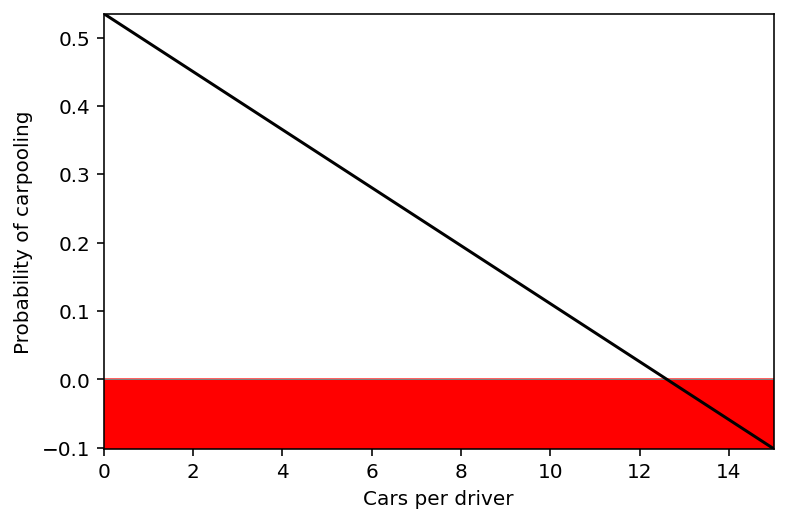

In [9]:
xs = np.array([0, 15])
ys = lpmFit.params.const + lpmFit.params.carsPerDriver * xs
plt.axhline(0, lw=0.5, color='gray')
plt.plot(xs, ys, color='black')
plt.xlim(*xs)
plt.ylim(*sorted(ys))
plt.xlabel('Cars per driver')
plt.ylabel('Probability of carpooling')
plt.savefig('../fig/linearprobabilitymodel.pdf', bbox_inches='tight')
plt.fill_between([-20, 20], [-20, 0], color='red')
plt.savefig('../fig/linearprobabilitymodel_highlight.pdf', bbox_inches='tight')

# Logit

In [10]:
logit = sm.Logit(carTrips.carpool, sm.add_constant(carTrips[['carsPerDriver']]))
logitFit = logit.fit()
logitFit.summary()

Optimization terminated successfully.
         Current function value: 0.691593
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                carpool   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9998
Method:                           MLE   Df Model:                            1
Date:                Thu, 27 Aug 2020   Pseudo R-squ.:                0.001504
Time:                        14:27:22   Log-Likelihood:                -6915.9
converged:                       True   LL-Null:                       -6926.4
Covariance Type:            nonrobust   LLR p-value:                 5.004e-06
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1440      0.050      2.865      0.004       0.045       0.243
carsPerDriver    -0.1738      0.039     -4.501      0.000      -0.250      -0.098
=================================================================================
"""

In [11]:
print(formatModel(logitFit))

\begin{tabular}{lrrrrrr}
\toprule
{} &  Coefficient &  Std. err. &  $t$-value &  $p$-value &  95\% Conf. &   Int. \\
\midrule
Constant        &        0.144 &      0.050 &      2.865 &      0.004 &      0.045 &  0.243 \\
Cars per driver &       -0.174 &      0.039 &     -4.501 &      0.000 &     -0.250 & -0.098 \\
\bottomrule
\end{tabular}
\begin{tabular}{lclc}
Dependent variable & \multicolumn{3}{l}{Carpool on trip} \\
Pseudo-$R^2$ & 0.00 & \\
Sample size & 10000 && \\
\end{tabular}



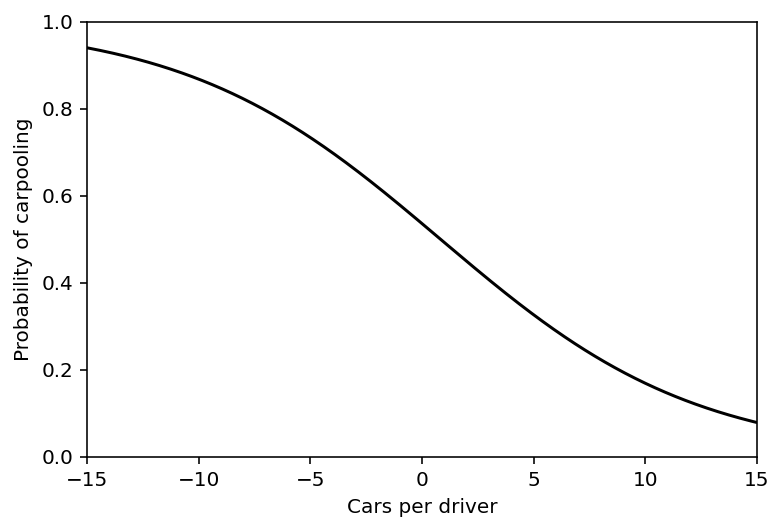

In [12]:
xs = np.arange(-15, 15, 0.05)
ys = logitFit.params.const + logitFit.params.carsPerDriver * xs
ys = np.exp(ys) / (1 + np.exp(ys))
plt.axhline(0, lw=0.5, color='gray')
plt.plot(xs, ys, color='black')
plt.xlim(-15, 15)
plt.ylim(0, 1)
plt.xlabel('Cars per driver')
plt.ylabel('Probability of carpooling')
plt.savefig('../fig/logit.pdf', bbox_inches='tight')

## Multinomial logit

In [13]:
# use data from biogeme
mnld = pd.read_csv('../data/optima.dat', sep='\t').sort_values('ID')
mnld['Choice'] = mnld.Choice.replace({-1: np.nan})

mnld['incomeChf'] = mnld.Income.map({
    1: 1250,
    2: 3250,
    3: 5000,
    4: 7000,
    5: 9000,
    6: 11000,
    -1: np.nan
}) / 1000
mnld['TimeWalk'] = mnld.TimeCar * 35 / 3 # assume average car trip at 35 mph, average walk at 3 mph
mnld['av'] = 1

db = bdb.Database('modechoice', mnld.dropna(subset=['incomeChf', 'Choice']))

In [14]:
betas = {
    'ascCar': Beta('ascCar', 0, None, None, 0),
    'ascPt': Beta('ascPt', 0, None, None, 0),
    'travelTime': Beta('travelTime', 0, None, None, 0),
    'incCar': Beta('incCar', 0, None, None, 0),
    'incPt': Beta('incPt', 0, None, None, 0)
}

In [15]:
# 0 = pt, 1 = car, 2 = walk
utilities = {
    0: betas['ascPt'] +   betas['travelTime'] * Variable('TimePT')   + betas['incPt']  * Variable('incomeChf'),
    1: betas['ascCar'] +  betas['travelTime'] * Variable('TimeCar')  + betas['incCar'] * Variable('incomeChf'),
    2:                    betas['travelTime'] * Variable('TimeWalk')
}

In [16]:
av = {
    0: Variable('av'),
    1: Variable('av'),
    2: Variable('av')
}

In [17]:
logprob = biogeme.models.loglogit(utilities, av, Variable('Choice'))

In [18]:
mnlFit = bio.BIOGEME(db, logprob)
mnlFit.modelName = 'SimpleMNL'
res = mnlFit.estimate()

In [19]:
pd.DataFrame(res.getGeneralStatistics()).transpose()[[0]]

,0
Number of estimated parameters,5
Sample size,1730
Excluded observations,0
Init log likelihood,-1900.6
Final log likelihood,-1250.3
Likelihood ratio test for the init. model,1300.61
Rho-square for the init. model,0.342157
Rho-square-bar for the init. model,0.339527
Akaike Information Criterion,2510.59
Bayesian Information Criterion,2537.87


In [20]:
print(res.getEstimatedParameters().round(2).to_latex())

\begin{tabular}{lrrrrrrr}
\toprule
{} &  Value &  Std err &  t-test &  p-value &  Rob. Std err &  Rob. t-test &  Rob. p-value \\
\midrule
ascCar     &   1.58 &     0.37 &    4.31 &      0.0 &          0.36 &         4.45 &           0.0 \\
ascPt      &   1.36 &     0.37 &    3.65 &      0.0 &          0.33 &         4.09 &           0.0 \\
incCar     &  -0.15 &     0.04 &   -3.42 &      0.0 &          0.04 &        -3.93 &           0.0 \\
incPt      &  -0.16 &     0.05 &   -3.47 &      0.0 &          0.04 &        -4.08 &           0.0 \\
travelTime &  -0.01 &     0.00 &  -11.77 &      0.0 &          0.00 &        -7.30 &           0.0 \\
\bottomrule
\end{tabular}

